<a href="https://colab.research.google.com/github/anandpol98/DCGAN/blob/main/dcgan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Convulational Generarive Adversarial Networks are comparatively stable GAN's while training compared to Normal GAN.


> Architecture guidelines for stable Deep Convolutional GANs


*   > Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
*   > Use batchnorm in both the generator and the discriminator.
*   > Remove fully connected hidden layers for deeper architectures.
*   > Use ReLU activation in generator for all layers except for the output, which uses Tanh.
*   > Use LeakyReLU activation in the discriminator for all layers.




In this implementation, DCGAN is trained over MNIST digit Dataset for over 10,000 epochs, after training model tries to generate dataset similar to MNIST, which can be seen at the end. Results are quite satisfactory and visually appealing.






# Importing Libraries

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from PIL import Image

# Image Specifications

In [ ]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

# Building Generator

In [ ]:
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    model.summary()
    noise = Input(shape=(latent_dim,))
    img = model(noise)
    return Model(noise, img)

# Building Discriminator

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)



# Optimizer, Compiling Combined Model

In [ ]:

optimizer = Adam(0.0002, 0.5)

# build discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# build generator
generator = build_generator()
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = True

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0

# Train the model

In [ ]:
def train(epochs, batch_size=128, save_interval=50):
    os.makedirs('images', exist_ok=True)
    
    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Select a random real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # Sample noise and generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)

        # Train the discriminator
        D_loss_real = discriminator.train_on_batch(real_imgs, valid)
        D_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid)

        # If at save interval
        if epoch % save_interval == 0:
            # Print the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, D_loss[0], 100 * D_loss[1], g_loss))
            # Save generated image samples
            save_imgs(epoch)


# Saving Images during training in epochs

In [ ]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

# Final Calling of all above utilities -> Training the Model

In [ ]:
start = time.time()

train(epochs=10000, batch_size=256, save_interval=1000)

end = time.time()
elapsed_train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),
                                                                     int((end - start) % 60))
print(elapsed_train_time)

os.makedirs('saved_model_weights', exist_ok=True)
generator.save_weights('saved_model_weights/generator_weights.h5')
discriminator.save_weights('saved_model_weights/discriminator_weights.h5')
combined.save_weights('saved_model_weights/combined_weights.h5')

11493376/11490434 [==============================] - 0s 0us/step
0 [D loss: 1.028726, acc.: 35.35%] [G loss: 1.011723]
1000 [D loss: 0.794815, acc.: 50.20%] [G loss: 0.493835]
2000 [D loss: 0.765878, acc.: 49.41%] [G loss: 0.444186]
3000 [D loss: 0.753406, acc.: 50.39%] [G loss: 0.444097]
4000 [D loss: 0.756138, acc.: 50.00%] [G loss: 0.448176]
5000 [D loss: 0.765191, acc.: 50.00%] [G loss: 0.435715]
6000 [D loss: 0.761769, acc.: 50.00%] [G loss: 0.424381]
7000 [D loss: 0.762592, acc.: 50.00%] [G loss: 0.426326]
8000 [D loss: 0.764678, acc.: 50.00%] [G loss: 0.422263]
9000 [D loss: 0.752904, acc.: 50.00%] [G loss: 0.413459]
elapsed training time: 15 min, 19 sec 


In [ ]:
# function for generating and saving images

def generate_and_save_images(model, epoch, test_input, save_img=False, folder='images'):
  if not os.path.exists(folder):
    os.mkdir(folder)
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8, 8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5,cmap='gray')
      plt.axis('off')

  if save_img:
    plt.savefig(f'{folder}/{folder}_{epoch:04d}.png')
  plt.show()

# Generate a image using DCGAN

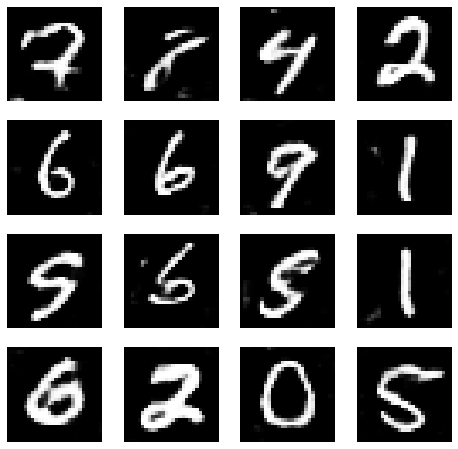

In [ ]:
# generate a image using DCGAN
num_seed_sets = 1
#seeds = np.random.normal(shape=[num_seed_sets, 1, 100])
seeds = np.random.normal(0, 1, [num_seed_sets,16, latent_dim])
# print(seeds)
for i in range(num_seed_sets):
  generate_and_save_images(generator, i, seeds[i], save_img=False, folder='samples')

# Creating GIF of output images

In [ ]:
anim_file = 'dcgan.gif'
import imageio
import glob

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('./images/*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.



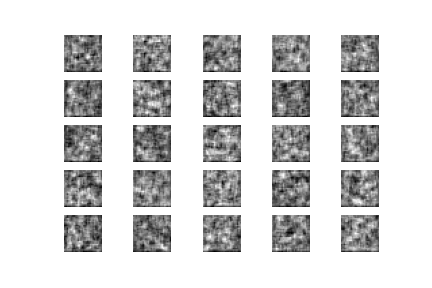

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs 
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

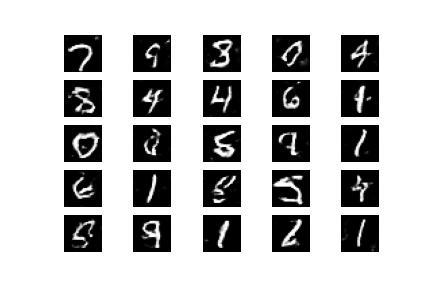

In [ ]:
from PIL import Image
Image.open('./images/mnist_5000.png')